# Statistical comparison between high resolution model (NATL60) and hydrographic data (EN4 dataset)

__author__ : Aurélie Albert & Julien Le Sommer (MEOM,IGE)

__context__ : 22-GLO-HR project : Lot 1 - Ocean Modelling

__date__ : 08 December 2017

__purpose__ : We propose to draw from the model an ensemble of vertical casts in a small neighborhood in space and time around an observation location and time. We extent this method to all observations within a geographic area, here the OSMOSIS area (18°W-13°Wx45°N-50°N).

__practical steps__ :

  * Input data are NATL60-CJM165 3D temperature and salinity and the EN4 dataset for 2012 and 2013.
  
  * step 1. : Selection of EN4 profiles that falls within the selected geographic area OSMOSIS and the selected period (4 seasons OND : october-november-december 2012, JFM : january-february-march 2013, AMJ : april-may-june 2013, JAS : july-august-september 2013)
  * step 2. : For each profiles selected in step 1, we extract the correspondant NATL60 data that are within 1° area and 15 days period around the location and time of the sampled profile.
  * step 3. : Every profiles within the OSMOSIS area are projected onto a standart vertical grid and bias between observations and model outputs are then averaged for every seasons defined in step 1.
  * step 4. : Averaged bias profiles are plotted and maps of the location of the observation profiles are produced.
  

__licence__ : This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

# 0 - Load modules

In [1]:
import sys
sys.path.insert(0,"/home/albert7a/lib/python")
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import glob as glob
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
import json
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 1 - Selection of EN4 profiles

This step is performed directly on occigen where the data are stored. We create a json file in which we store, for each profile selected, the reference name, the date and location of sampling and the name of the file containing it. An example of such a file can be seen [here](osmo_spring.json)


# 2 - Extraction of NATL60 outputs

For each profile stored in the json file previously written in step 1, we extract from NATL60 outputs all the modelled profiles that fall within 1° and 15 days around the location and date of the observation profile. We create a netcdf file containing the observed profile, the mean, percent 10 and 90 of all modelled profiles close to the observation profile, for both Temperature and Salinity. Each observation profile has its own vertical grid and we look in the 300 levels of the NATL60 outputs for the closest vertical level.

# 3 - Projection on a standart vertical grid

Inputs are the json files containing the list of observation profiles for all seasons and all the netcdf files created in step 2.

In [2]:
# A big function that plots the averaged bias for one season from jsonfile

def plot_bias_from_jsonfile(jsonfile,ax1,ax2,season):
    
    sourcefile=open(jsonfile,'rU')
    infos=json.load(sourcefile)
    nb_profilesEN4=len(infos)

    vert_standart=[0,2,4,6,8,10,12,14,16,18,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,140,150,160,170,180,190,200,220,240,260,280,300,320,340,360,380,400,420,440,460,480,500,520,540,560,580,600,620,640,660,680,700,720,740,760,780,800,820,840,860,880,900,920,940,960,980,1000,1050,1100,1150,1200,1250,1300,1350,1400,1450,1500,1550,1600,1650,1700,1750,1800,1850,1900,1950,2000]


    all_temp_mean_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_salt_mean_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_temp_en4=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_salt_en4=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_temp_percent10_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_salt_percent10_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_temp_percent90_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_salt_percent90_model=np.zeros((nb_profilesEN4,len(vert_standart)))

# Read one netcdf files and loading obs and model data for one profile
    def get_netcdf_profiles(jsonfile,infos,prof,namezone):
        list_profiles = infos.keys()
        reference_profile = str(list_profiles[prof])
        
        
        dirname="/media/extra/DATA/EN4/profiles_files/"+namezone
        netcdf_name=dirname+"/profiles_EN4-"+reference_profile[1:]+"_NATL60-CJM165_TS.nc"
        dsprof=xr.open_dataset(netcdf_name)

        depth_en4=dsprof['depth_en4']
        depth_model=dsprof['depth_model']
        temp_en4=dsprof['temp_profileEN4']
        salt_en4=dsprof['salt_profileEN4']
        mean_temp_model=dsprof['mean_temp_model']
        mean_salt_model=dsprof['mean_salt_model']
        percent10_temp_model=dsprof['percent10_temp_model']
        percent10_salt_model=dsprof['percent10_salt_model']
        percent90_temp_model=dsprof['percent90_temp_model']
        percent90_salt_model=dsprof['percent90_salt_model']



        return depth_en4,depth_model,temp_en4,salt_en4,mean_temp_model,mean_salt_model,percent10_temp_model,percent10_salt_model,percent90_temp_model,percent90_salt_model

# Project obs and model data onto a standart vertical grid using simple interpolation
    def project_standart_vertical_levels(depth_en4,depth_model,temp_en4,salt_en4,mean_temp_model,mean_salt_model,percent10_temp_model,percent10_salt_model,percent90_temp_model,percent90_salt_model,vert_standart):

        temp_en4_standart=np.zeros(len(vert_standart))
        salt_en4_standart=np.zeros(len(vert_standart))
        mean_temp_model_standart=np.zeros(len(vert_standart))
        mean_salt_model_standart=np.zeros(len(vert_standart))
        percent10_temp_model_standart=np.zeros(len(vert_standart))
        percent10_salt_model_standart=np.zeros(len(vert_standart))
        percent90_temp_model_standart=np.zeros(len(vert_standart))
        percent90_salt_model_standart=np.zeros(len(vert_standart))

        for k in np.arange(len(vert_standart)-1):
            zs1=vert_standart[k]
            zs2=vert_standart[k+1]
            zs=(zs1+zs2)/2.
            idz=np.where(np.abs(depth_en4-zs)==np.min(np.abs(depth_en4-zs)))
            idz0=np.min(idz[0])
            if (idz0==0) | (idz0==len(depth_en4)-1):
                temp_en4_standart[k]='nan'
                salt_en4_standart[k]='nan'
                mean_temp_model_standart[k]='nan'
                mean_salt_model_standart[k]='nan'
                percent10_temp_model_standart[k]='nan'
                percent10_salt_model_standart[k]='nan'
                percent90_temp_model_standart[k]='nan'
                percent90_salt_model_standart[k]='nan'
            else:
                if depth_en4[idz0] < zs:
                    temp_en4_standart[k]=(1 - (zs-depth_en4[idz0])/(depth_en4[idz0+1]-depth_en4[idz0])) * temp_en4[idz0] + (1 - (depth_en4[idz0+1] - zs)/(depth_en4[idz0+1]-depth_en4[idz0])) * temp_en4[idz0+1]
                    salt_en4_standart[k]=(1 - (zs-depth_en4[idz0])/(depth_en4[idz0+1]-depth_en4[idz0])) * salt_en4[idz0] + (1 - (depth_en4[idz0+1] - zs)/(depth_en4[idz0+1]-depth_en4[idz0])) * salt_en4[idz0+1]
                    mean_temp_model_standart[k]=(1 - (zs-depth_en4[idz0])/(depth_en4[idz0+1]-depth_en4[idz0])) * mean_temp_model[idz0] + (1 - (depth_en4[idz0+1] - zs)/(depth_en4[idz0+1]-depth_en4[idz0])) * mean_temp_model[idz0+1]
                    mean_salt_model_standart[k]=(1 - (zs-depth_en4[idz0])/(depth_en4[idz0+1]-depth_en4[idz0])) * mean_salt_model[idz0] + (1 - (depth_en4[idz0+1] - zs)/(depth_en4[idz0+1]-depth_en4[idz0])) * mean_salt_model[idz0+1]
                    percent10_temp_model_standart[k]=(1 - (zs-depth_en4[idz0])/(depth_en4[idz0+1]-depth_en4[idz0])) * percent10_temp_model[idz0] + (1 - (depth_en4[idz0+1] - zs)/(depth_en4[idz0+1]-depth_en4[idz0])) * percent10_temp_model[idz0+1]
                    percent10_salt_model_standart[k]=(1 - (zs-depth_en4[idz0])/(depth_en4[idz0+1]-depth_en4[idz0])) * percent10_salt_model[idz0] + (1 - (depth_en4[idz0+1] - zs)/(depth_en4[idz0+1]-depth_en4[idz0])) * percent10_salt_model[idz0+1]
                    percent90_temp_model_standart[k]=(1 - (zs-depth_en4[idz0])/(depth_en4[idz0+1]-depth_en4[idz0])) * percent90_temp_model[idz0] + (1 - (depth_en4[idz0+1] - zs)/(depth_en4[idz0+1]-depth_en4[idz0])) * percent90_temp_model[idz0+1]
                    percent90_salt_model_standart[k]=(1 - (zs-depth_en4[idz0])/(depth_en4[idz0+1]-depth_en4[idz0])) * percent90_salt_model[idz0] + (1 - (depth_en4[idz0+1] - zs)/(depth_en4[idz0+1]-depth_en4[idz0])) * percent90_salt_model[idz0+1]
                    
                if depth_en4[idz0] > zs:
                    temp_en4_standart[k]=(1 - (zs-depth_en4[idz0-1])/(depth_en4[idz0]-depth_en4[idz0-1])) * temp_en4[idz0-1] + (1 - (depth_en4[idz0] - zs)/(depth_en4[idz0]-depth_en4[idz0-1])) * temp_en4[idz0]
                    salt_en4_standart[k]=(1 - (zs-depth_en4[idz0-1])/(depth_en4[idz0]-depth_en4[idz0-1])) * salt_en4[idz0-1] + (1 - (depth_en4[idz0] - zs)/(depth_en4[idz0]-depth_en4[idz0-1])) * salt_en4[idz0]
                    mean_temp_model_standart[k]=(1 - (zs-depth_en4[idz0-1])/(depth_en4[idz0]-depth_en4[idz0-1])) * mean_temp_model[idz0-1] + (1 - (depth_en4[idz0] - zs)/(depth_en4[idz0]-depth_en4[idz0-1])) * mean_temp_model[idz0]
                    mean_salt_model_standart[k]=(1 - (zs-depth_en4[idz0-1])/(depth_en4[idz0]-depth_en4[idz0-1])) * mean_salt_model[idz0-1] + (1 - (depth_en4[idz0] - zs)/(depth_en4[idz0]-depth_en4[idz0-1])) * mean_salt_model[idz0]
                    percent10_temp_model_standart[k]=(1 - (zs-depth_en4[idz0-1])/(depth_en4[idz0]-depth_en4[idz0-1])) * percent10_temp_model[idz0-1] + (1 - (depth_en4[idz0] - zs)/(depth_en4[idz0]-depth_en4[idz0-1])) * percent10_temp_model[idz0]
                    percent10_salt_model_standart[k]=(1 - (zs-depth_en4[idz0-1])/(depth_en4[idz0]-depth_en4[idz0-1])) * percent10_salt_model[idz0-1] + (1 - (depth_en4[idz0] - zs)/(depth_en4[idz0]-depth_en4[idz0-1])) * percent10_salt_model[idz0]
                    percent90_temp_model_standart[k]=(1 - (zs-depth_en4[idz0-1])/(depth_en4[idz0]-depth_en4[idz0-1])) * percent90_temp_model[idz0-1] + (1 - (depth_en4[idz0] - zs)/(depth_en4[idz0]-depth_en4[idz0-1])) * percent90_temp_model[idz0]
                    percent90_salt_model_standart[k]=(1 - (zs-depth_en4[idz0-1])/(depth_en4[idz0]-depth_en4[idz0-1])) * percent90_salt_model[idz0-1] + (1 - (depth_en4[idz0] - zs)/(depth_en4[idz0]-depth_en4[idz0-1])) * percent90_salt_model[idz0]

                if depth_en4[idz0] == zs:
                    temp_en4_standart[k]= temp_en4[idz0]
                    salt_en4_standart[k]= salt_en4[idz0]
                    mean_temp_model_standart[k]= mean_temp_model[idz0]
                    mean_salt_model_standart[k]= mean_salt_model[idz0]
                    percent10_temp_model_standart[k]= percent10_temp_model[idz0]
                    percent10_salt_model_standart[k]= percent10_salt_model[idz0]
                    percent90_temp_model_standart[k]= percent90_temp_model[idz0]
                    percent90_salt_model_standart[k]= percent90_salt_model[idz0]


        return temp_en4_standart,salt_en4_standart,mean_temp_model_standart,mean_salt_model_standart,percent10_temp_model_standart,percent10_salt_model_standart,percent90_temp_model_standart,percent90_salt_model_standart

# Loop on all profiles listed in the json file, we keep only the profiles that go deeper than 500m
    for prof in np.arange(nb_profilesEN4):
        depth_en4,depth_model,temp_en4,salt_en4,mean_temp_model,mean_salt_model,percent10_temp_model,percent10_salt_model,percent90_temp_model,percent90_salt_model = get_netcdf_profiles(jsonfile,infos,prof,'osmo')
        if depth_en4[-1] > 500:
            temp_en4_standart,salt_en4_standart,mean_temp_model_standart,mean_salt_model_standart,percent10_temp_model_standart,percent10_salt_model_standart,percent90_temp_model_standart,percent90_salt_model_standart = project_standart_vertical_levels(depth_en4,depth_model,temp_en4,salt_en4,mean_temp_model,mean_salt_model,percent10_temp_model,percent10_salt_model,percent90_temp_model,percent90_salt_model,vert_standart)
            all_temp_mean_model[prof,:]=mean_temp_model_standart[:]
            all_salt_mean_model[prof,:]=mean_salt_model_standart[:]
            all_temp_en4[prof,:]=temp_en4_standart[:]
            all_salt_en4[prof,:]=salt_en4_standart[:]
            all_temp_percent10_model[prof,:]=percent10_temp_model_standart[:]
            all_salt_percent10_model[prof,:]=percent10_salt_model_standart[:]
            all_temp_percent90_model[prof,:]=percent90_temp_model_standart[:]
            all_salt_percent90_model[prof,:]=percent90_salt_model_standart[:]

# We replace 0. (no values for this level) by NaN, so it wont be averaged with the other values
    all_temp_mean_model[all_temp_mean_model==0.]='nan'
    all_salt_mean_model[all_salt_mean_model==0.]='nan'
    all_temp_en4[all_temp_en4==0.]='nan'
    all_salt_en4[all_salt_en4==0.]='nan'
    all_temp_percent10_model[all_temp_percent10_model==0.]='nan'
    all_salt_percent10_model[all_salt_percent10_model==0.]='nan'
    all_temp_percent90_model[all_temp_percent90_model==0.]='nan'
    all_salt_percent90_model[all_salt_percent90_model==0.]='nan'

# Mean Bias are computed
    all_temp_bias=all_temp_mean_model-all_temp_en4
    mean_temp_bias=np.nanmin(all_temp_bias,0)
    all_salt_bias=all_salt_mean_model-all_salt_en4
    mean_salt_bias=np.nanmin(all_salt_bias,0)
    all_temp_percent10_cent=all_temp_percent10_model-all_temp_mean_model
    all_temp_percent10_bias=all_temp_percent10_model-all_temp_en4
    temp_percent10=np.nanmin(all_temp_percent10_cent,0)
    temp_percent10_bias=np.nanmin(all_temp_percent10_bias,0)
    all_salt_percent10_cent=all_salt_percent10_model-all_salt_mean_model
    all_salt_percent10_bias=all_salt_percent10_model-all_salt_en4
    salt_percent10=np.nanmin(all_salt_percent10_cent,0)
    salt_percent10_bias=np.nanmin(all_salt_percent10_bias,0)
    all_temp_percent90_cent=all_temp_percent90_model-all_temp_mean_model
    all_temp_percent90_bias=all_temp_percent90_model-all_temp_en4
    temp_percent90=np.nanmin(all_temp_percent90_cent,0)
    temp_percent90_bias=np.nanmin(all_temp_percent90_bias,0)
    all_salt_percent90_cent=all_salt_percent90_model-all_salt_mean_model
    all_salt_percent90_bias=all_salt_percent90_model-all_salt_en4
    salt_percent90=np.nanmin(all_salt_percent90_cent,0)
    salt_percent90_bias=np.nanmin(all_salt_percent90_bias,0)

# Plots for one season : mean, percent 10 and percent 90 bias of Temperature and Salinity
    ax1.plot(mean_temp_bias,vert_standart,'b.-', label='mean bias')
    ax1.set_xlabel('Bias in temperature $^\circ$C in '+season, size=16)
    ax1.set_ylabel('Depth [m]', size=14)
    ax1.set_ylim(2000, 0)
    ax1.grid(True, which='both')
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top') 
    ax1.axvline(0,color='k')
    ax1.plot(temp_percent10_bias,vert_standart,'b-', label='percent10')
    ax1.plot(temp_percent90_bias,vert_standart,'b-', label='percent90')
    ax1.fill_betweenx(vert_standart, temp_percent10_bias, x2=temp_percent90_bias, alpha=0.2, facecolor='b')

    
    ax2.plot(mean_salt_bias,vert_standart,'b.-', label='mean bias')
    ax2.set_xlabel('Bias in salinity PSU in '+season, size=16)
    ax2.set_ylabel('Depth [m]', size=14)
    ax2.set_ylim(2000, 0)
    ax2.grid(True, which='both')
    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position('top') 
    ax2.axvline(0,color='k')
    ax2.plot(salt_percent10_bias,vert_standart,'b-', label='percent10')
    ax2.plot(salt_percent90_bias,vert_standart,'b-', label='percent90')
    ax2.fill_betweenx(vert_standart, salt_percent10_bias, x2=salt_percent90_bias, alpha=0.2, facecolor='b')


# 4 - Maps and plots

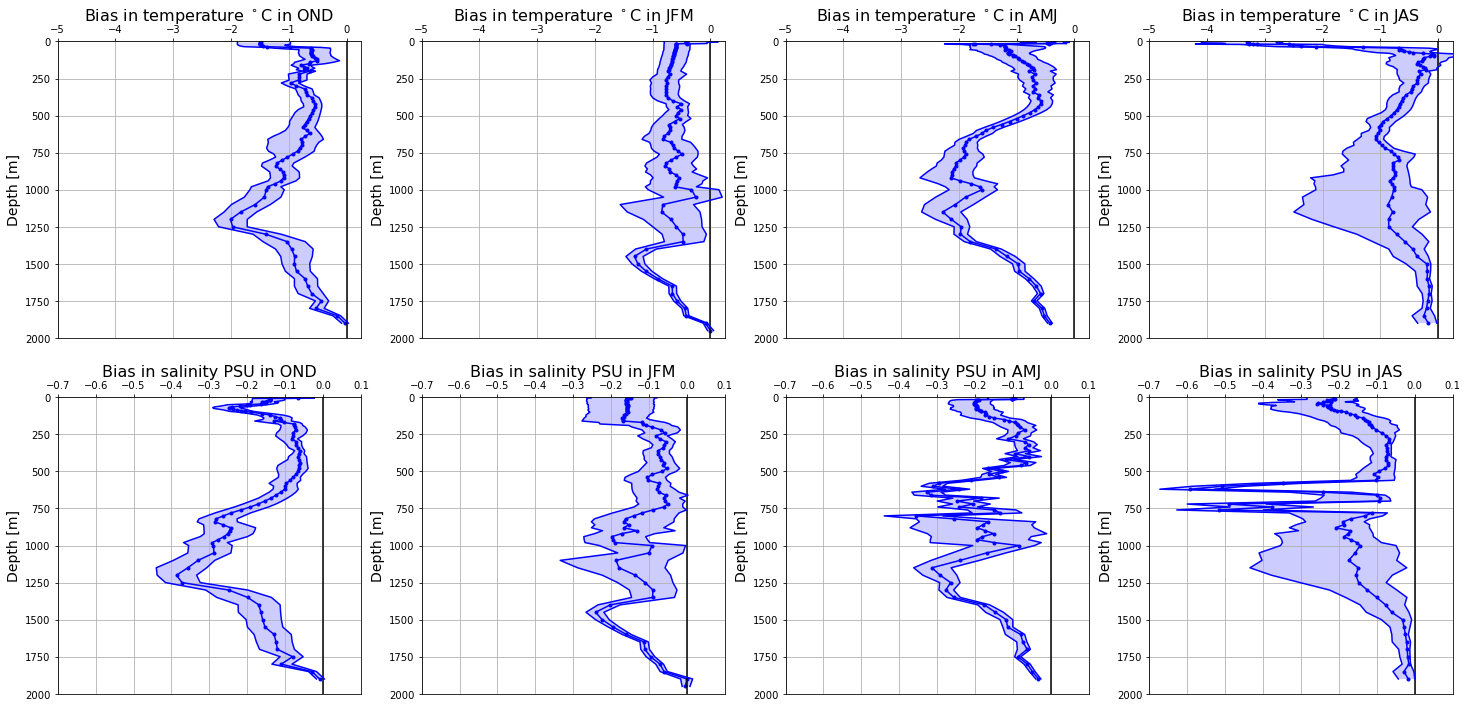

In [4]:
# Plots for all 4 seasons

gs = gridspec.GridSpec(2, 4, width_ratios=[1,1,1,1], height_ratios=[2,2])
fig1 = plt.figure(figsize=(25, 12))  # (w,h)

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0])
plot_bias_from_jsonfile('osmo_autumn.json',ax1,ax2,'OND')
ax1.set_xlim(-5,0.25)
ax2.set_xlim(-0.7,0.1)
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,1])
plot_bias_from_jsonfile('osmo_winter.json',ax1,ax2,'JFM')
ax1.set_xlim(-5,0.25)
ax2.set_xlim(-0.7,0.1)
ax1 = plt.subplot(gs[0,2])
ax2 = plt.subplot(gs[1,2])
plot_bias_from_jsonfile('osmo_spring.json',ax1,ax2,'AMJ')
ax1.set_xlim(-5,0.25)
ax2.set_xlim(-0.7,0.1)
ax1 = plt.subplot(gs[0,3])
ax2 = plt.subplot(gs[1,3])
plot_bias_from_jsonfile('osmo_summer.json',ax1,ax2,'JAS')
ax1.set_xlim(-5,0.25)
ax2.set_xlim(-0.7,0.1)

plt.savefig('bias_TS_osmo.png',bbox_inches='tight')

In [4]:
# Given the list of profiles in seasonal json file, we make a map of the location of these profiles
def map_profiles_from_jsonfile(jsonfile,ax1,season):
    
    sourcefile=open(jsonfile,'rU')
    infos=json.load(sourcefile)
    nb_profilesEN4=len(infos)

    all_lat=np.zeros((nb_profilesEN4))
    all_lon=np.zeros((nb_profilesEN4))

# We only retrieve lat and lon of the observed profile from each netcdf file    
    def get_netcdf_profiles(jsonfile,infos,prof,namezone):
        list_profiles = infos.keys()
        reference_profile = str(list_profiles[prof])
        
        
        dirname="/media/extra/DATA/EN4/profiles_files/"+namezone
        netcdf_name=dirname+"/profiles_EN4-"+reference_profile[1:]+"_NATL60-CJM165_TS.nc"
        dsprof=xr.open_dataset(netcdf_name)

        depth_en4=dsprof['depth_en4']
        lat=dsprof['latitude_profileEN4']
        lon=dsprof['longitude_profileEN4']
        
        return depth_en4,lat,lon

    for prof in np.arange(nb_profilesEN4):
        depth_en4,lat,lon = get_netcdf_profiles(jsonfile,infos,prof,'osmo')
        if depth_en4[-1] > 500:
            all_lat[prof]=lat[:]
            all_lon[prof]=lon[:]

    all_lat[all_lat==0.]='nan'
    all_lon[all_lon==0.]='nan'
            
    lamin=np.nanmin(all_lat)
    lamax=np.nanmax(all_lat)
    lomin=np.nanmin(all_lon)
    lomax=np.nanmax(all_lon)
    
# The maps are created
    my_map0 = Basemap(projection='merc', lat_0=(lamin+lamax)/2, lon_0=(lomin+lomax)/2, 
    resolution = 'i', 
    llcrnrlon = lomin-1, llcrnrlat= lamin-1,
    urcrnrlon = lomax+1, urcrnrlat = lamax+1, area_thresh = 10)

    my_map0.drawcoastlines() 
    my_map0.drawmapboundary()
    my_map0.drawmeridians(np.arange(-120, 60, 2), labels=[1,0,0,1], size=18);
    my_map0.drawparallels(np.arange(0, 80, 2), labels=[1,0,0,1], size=18);
    my_map0.scatter(all_lon, all_lat, latlon=True, c='g', linewidth='0', s=18);
    plt.title('EN4 profiles in '+season, size=20);



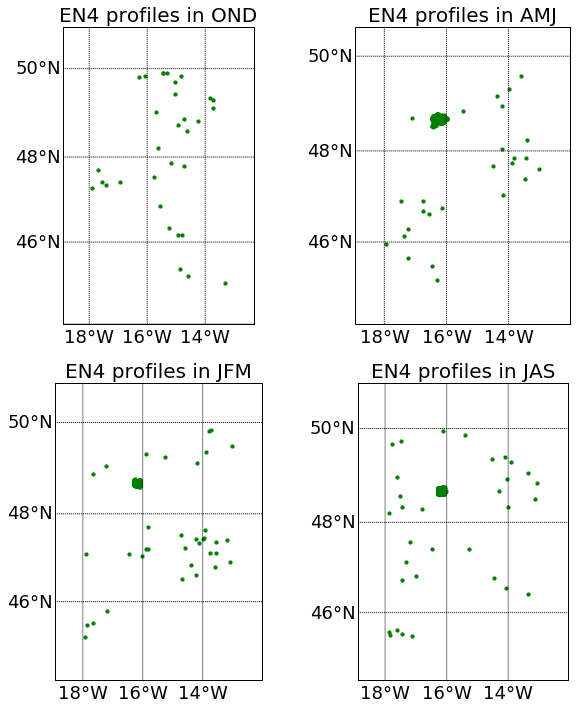

In [5]:
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[1,1])
fig1 = plt.figure(figsize=(10,12))  # (w,h)

ax1 = plt.subplot(gs[0,0])
map_profiles_from_jsonfile('osmo_autumn.json',ax1,'OND')
ax1 = plt.subplot(gs[1,0])
map_profiles_from_jsonfile('osmo_winter.json',ax1,'JFM')
ax1 = plt.subplot(gs[0,1])
map_profiles_from_jsonfile('osmo_spring.json',ax1,'AMJ')
ax1 = plt.subplot(gs[1,1])
map_profiles_from_jsonfile('osmo_summer.json',ax1,'JAS')

plt.savefig("maps_osmo_seasons.png")